In [2]:
# pip install camelot-py[all]
# https://ghostscript.com/releases/gsdnld.html

import camelot
import pandas as pd

from datetime import datetime
from joblib import Parallel, delayed
import os
import fitz  # PyMuPDF

In [3]:
pdf_path = r"\\courageous\Administration\Executive\CRR\Boxes\James\Form 5500\PDFs"
table_path = r"\\courageous\Administration\Executive\CRR\Boxes\James\Form 5500\Tables"

project_folder = r"\\courageous\Administration\Executive\CRR\CRRMicroDataFiles\5500\DATA\5500Filings"

filename = '20230726202613NAL0022710626001'

In [5]:
filename_list = []

# List all files in the directory
for filename in os.listdir(os.path.join(project_folder, "Data", "PDFs", "2022")):
    if filename.lower().endswith(".pdf"):
        # Remove the .pdf extension and append to the list
        filename_list.append(filename[:-4])


In [7]:
filename_list[0:2]

['20230103134231NAL0002290481001', '20230105085705NAL0004499889001']

In [8]:
filename_list = filename_list[0:81]

In [13]:
def extract_pages(pdf_document, target_text):
    found_pages = []
    # Iterate through each page in the PDF
    for page_number in range(pdf_document.page_count):
        # Get the page
        page = pdf_document[page_number]

        # Search for the target text in the page's text
        if target_text in page.get_text():
            found_pages.append(page_number + 1)  # Page numbers are 1-based

    return found_pages

In [14]:
# This finds pages containing given text
def find_pages(pdf_path, filename):
    # Open the PDF file
    pdf_document = fitz.open(os.path.join(pdf_path, f'{filename}.pdf'))
    
    # Extract Pages
    pages0 = extract_pages(pdf_document, "See Independent Auditor's Report on Supplementary Information")
    pages0_not = extract_pages(pdf_document, "Explanation of Loans and Fixed Income Obligations in Default") + extract_pages(pdf_document, "5500 Acquisitions & Dispositions") + extract_pages(pdf_document, "Schedule of Reportable Transactions")
    pages0 = [page for page in pages0 if page not in pages0_not]
    pages1 = extract_pages(pdf_document, "Years of Credited Service")
    pages2 = extract_pages(pdf_document, "Expected Benefit Payments")
    pages3 = extract_pages(pdf_document, "Schedule of Projection of Employer Contributions and Withdrawal")
    
    # Close the PDF file
    pdf_document.close()

    pages0 = str(pages0).replace("[","").replace("]","")
    pages1 = str(pages1).replace("[","").replace("]","")
    pages2 = str(pages2).replace("[","").replace("]","")
    pages3 = str(pages3).replace("[","").replace("]","")

    return pages0, pages1, pages2, pages3

In [15]:
def extract_table(pdf_path, table_path, year, filename):
    # This finds pages containing given text
    pages0, pages1, pages2, pages3 = find_pages(pdf_path, filename)
    
    ### See Independent Auditor's Report on Supplementary Information - 5500 Acquisitions & Dispositions/Schedule of Assets
    # Read PDF and extract tables
    tables0 = camelot.read_pdf(os.path.join(pdf_path, f'{filename}.pdf'), flavor='stream', edge_tol=500, pages=pages0)
       
    # Append tables
    table0_list = []
    # Loop through the tables and append to table0_list
    for table0 in tables0:
        # Check if the DataFrame has 5 columns
        if table0.df.shape[1] != 5:
            # Rename the existing columns
            table0.df.columns = [(i + 1) if i > 0 else 0 for i in range(table0.df.shape[1])]
            # Insert a blank column after '0' and name it '1'
            table0.df.insert(1, 1, '')
        # Append the modified DataFrame to the list
        table0_list.append(table0.df)

    table0 = pd.concat(table0_list, axis=0)
    table0.drop_duplicates(subset=[2, 3, 4], keep='first', inplace=True)
    # table0 drop duplicates on 2, 3, 4 keep if not 1 blank
    
    # Save
    table0.to_csv(os.path.join(table_path, f'{filename} Assets.csv'), index=False)
    
    
    ### Years of Credited Service/Schedule of Active Participants
    # Read PDF and extract tables
    tables1 = camelot.read_pdf(os.path.join(project_folder, "Data", "PDFs", f"{year}", f'{filename}.pdf'), flavor='stream', pages=pages1)
    
    # Append tables
    table1_list = []
    for table1 in tables1:
        table1_list.append(table1.df)
    table1 = pd.concat(table1_list, axis=0)
    
    # Save
    table1.to_csv(os.path.join(project_folder, "Data", "Tables", f"{year}", f'{filename} Active Benefits.csv'), index=False)
    
    
    ### Expected Benefit Payments/Schedule of Projected Benefits
    # Read PDF and extract tables
    tables2 = camelot.read_pdf(os.path.join(project_folder, "Data", "PDFs", f"{year}", f'{filename}.pdf'), flavor='stream', pages=pages2)
    
    # Append tables
    table2_list = []
    for table2 in tables2:
        table2_list.append(table2.df)
    table2 = pd.concat(table2_list, axis=0)
    
    # Save
    table2.to_csv(os.path.join(os.path.join(project_folder, "Data", "Tables", f"{year}", f'{filename} Projected Benefits.csv'), index=False)
    
    
    ### Schedule of Projection of Employer Contributions and Withdrawal/Schedule of Contrib and Wthdrwl
    # Read PDF and extract tables
    tables3 = camelot.read_pdf(os.path.join(project_folder, "Data", "PDFs", f"{year}", f'{filename}.pdf'), flavor='stream', pages=pages3)
    
    # Append tables
    table3_list = []
    for table3 in tables2:
        table3_list.append(table3.df)
    table3 = pd.concat(table3_list, axis=0)
    
    # Save
    table3.to_csv(os.path.join(os.path.join(project_folder, "Data", "Tables", f"{year}", f'{filename} Contrib and Wthdrwl.csv'), index=False)
    
    
    return tables0

SyntaxError: invalid syntax (1015293527.py, line 60)

In [55]:
%%time
tables0 = extract_table(pdf_path, table_path, filename)

CPU times: total: 1min 36s
Wall time: 1min 50s


In [56]:
# i = 0
# for dff in tables0:
#     print("Table", i)
#     print(dff.df.head())
#     i+=1

C:\Users\james\AppData\Local\Temp\ipykernel_3872\2546631740.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables0[0], kind='text').show()


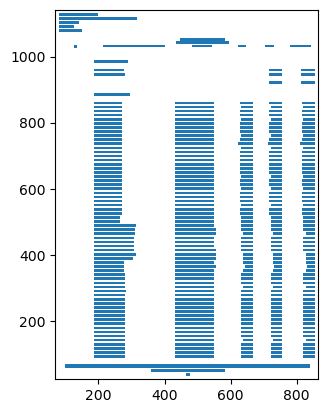

In [57]:
camelot.plot(tables0[0], kind='text').show()

In [58]:
%%time
results = Parallel(n_jobs=-1)(delayed(extract_table)(pdf_path, table_path, filename) for filename in filename_list)

CPU times: total: 2.53 s
Wall time: 5min 23s


In [ ]:
# You might want to use position to identify columns, can use plot to get an idea of where 

In [ ]:
# # Plan
# Loop over Stata file to get PDFs

# Loop over Stata file again to extract info, clean PDFs
#     There are variables that tell us which files we need, just need to make sure there's a function for each type. 

##Loop again to clean